In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
covid = gpd.read_file('datos/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)

In [3]:
covid.head()

clasificac  fallecido codpcia departamen  \
link mes                                             
2001 1        1266.0       20.0      02   Comuna 1   
     2         748.0       11.0      02   Comuna 1   
     3         994.0       20.0      02   Comuna 1   
     4        2071.0       50.0      02   Comuna 1   
     5        3575.0       44.0      02   Comuna 1   

                                 provincia  mujeres  varones  personas  \
link mes                                                                 
2001 1    Ciudad AutÃ³noma de Buenos Aires   107789    98097    205886   
     2    Ciudad AutÃ³noma de Buenos Aires   107789    98097    205886   
     3    Ciudad AutÃ³noma de Buenos Aires   107789    98097    205886   
     4    Ciudad AutÃ³noma de Buenos Aires   107789    98097    205886   
     5    Ciudad AutÃ³noma de Buenos Aires   107789    98097    205886   

          hogares  viv_part  viv_part_h  lq_confirm  lq_falleci  \
link mes                                                          
2001 1      84468    130771       78360    0.857827    0.670509   
     2      84468    130771       78360    0.861241    0.550424   
     3      84468    130771       78360    0.801510    0.712041   
     4      84468    130771       78360    0.905041    0.979441   
     5      84468    130771       78360    1.310885    1.168038   

                                                   geometry  
link mes                                                     
2001 1    POLYGON ((-58.37501 -34.57959, -58.36690 -34.5...  
     2    POLYGON ((-58.37501 -34.57959, -58.36690 -34.5...  
     3    POLYGON ((-58.37501 -34.57959, -58.36690 -34.5...  
     4    POLYGON ((-58.37501 -34.57959, -58.36690 -34.5...  
     5    POLYGON ((-58.37501 -34.57959, -58.36690 -34.5...

In [4]:
# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,1],'geometry']
codiprov = covid.loc[pd.IndexSlice[:,1],'codpcia']

#  dividimos la cantidad de casos y fallecidos por la población
columnas = ['clasificac', 'fallecido']
covid2 = covid.copy()
for i in columnas:
    covid2[i] = covid[i]/covid.personas*100
covid2 = covid2[columnas]
casos = covid2.iloc[:,0].to_numpy().reshape(525,12) #se selecciona solo una columna del df

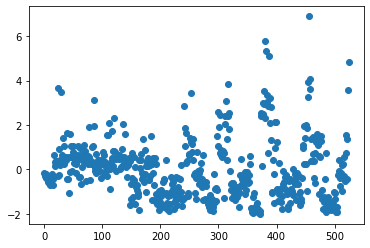

In [197]:
# Análisis de componentes principales 
from sklearn.decomposition import PCA
pca = PCA(1)
casos_pca = pca.fit_transform(casos)
plt.scatter(range(len(casos_pca)),casos_pca[:,0])

In [198]:
pca.score(casos)

-9.540266933443199

In [199]:
def siluetas(X, model):
    return silhouette_score(X, model.labels_)
from sklearn.metrics import silhouette_score 

In [262]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from copy import copy
import time
import sys
class metodo():
    def __init__(self, metodo, param,metric):
        
        # Parameters: 
        # metodo: It is the clustering metodology of scikit learn
        # param: Dictionary of  metodos's parameters 
        self.metodo = metodo
        self.param = param
        self.metric = metric
    def grid(self):
        from sklearn.model_selection import ParameterGrid
        parametros = list(ParameterGrid(self.param))
        return parametros
    
    def modelo(self, diccionario_parametros):
        dic = diccionario_parametros
        kmean = {'n_clusters': 8, 'init': 'k-means++', 'n_init': 10, 'max_iter':300, 'tol': 0.0001}
        aglo = {'n_clusters': 8, 'affinity': 'euclidean', 'memory': None, 'connectivity':None, 'linkage': 'ward'}
        if str(type(self.metodo)) == "<class 'sklearn.cluster._kmeans.KMeans'>":
            for k in kmean.keys():
                try:
                    kmean[k] = dic[k] 
                except KeyError:
                    pass                  
            metod = copy(self.metodo)    
            metod.__init__(n_clusters = kmean['n_clusters'], init = kmean['init'], n_init = kmean['n_init'], tol = kmean['tol'])
            return metod
        
        elif str(type(self.metodo)) == "<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>":
            for k in aglo.keys():
                try:
                    aglo[k] = dic[k] 
                except KeyError:
                    pass                  
            metod = copy(self.metodo)    
            metod.__init__(n_clusters = aglo['n_clusters'], affinity = aglo['affinity'], memory = aglo['memory'], connectivity = aglo['connectivity'],linkage = aglo['linkage'] )
            return metod
        
        else:
            print('no se reconoce el método')
            
            
    def fit(self, data):
        p = self.grid()
        self.parametros = p
        modelos = []
        for dic in p:
            try:
                model = self.modelo(dic)
                inicio = time.time()
                model.fit(data)
                rdo = self.metric(data, model)
                tiempo = time.time()-inicio
                modelos.append([model,rdo,tiempo, sys.getsizeof(model)])
            except:
                pass
        modelos = pd.DataFrame(modelos, columns = ('modelo','Metrica', 'tiempo','Tamaño'))
        self.modelos = modelos
        self.best_model_ = self.modelos[self.modelos.Metrica == self.modelos.Metrica.max()]
        self.best_time_ = self.modelos[self.modelos.tiempo == self.modelos.tiempo.min()]
    
        

## Eligiendo metodo

Buscamos dentro de una combinación de parámetros aquel que mejor metrica tenga

In [263]:
hiperparam = {
    'n_clusters': np.arange(5,100,5), 'init': ['k-means++', 'random'],
    'n_init' : [10,12,15,20]
}


kmeans = metodo(KMeans(), hiperparam, siluetas)
kmeans.fit(casos)
kmeans.modelos


,modelo,Metrica,tiempo,Tamaño
0,KMeans(n_clusters=5),0.269894,0.092748,56
1,"KMeans(n_clusters=5, n_init=12)",0.273677,0.109707,56
2,"KMeans(n_clusters=5, n_init=15)",0.269874,0.118681,56
3,"KMeans(n_clusters=5, n_init=20)",0.247811,0.169547,56
4,KMeans(n_clusters=10),0.201111,0.129653,56
...,...,...,...,...
147,"KMeans(init='random', n_clusters=90, n_init=20)",0.118057,0.270277,56
148,"KMeans(init='random', n_clusters=95)",0.112524,0.150598,56
149,"KMeans(init='random', n_clusters=95, n_init=12)",0.110907,0.151594,56
150,"KMeans(init='random', n_clusters=95, n_init=15)",0.107075,0.182513,56


In [202]:
kmeans.best_model_

,modelo,Metrica,tiempo,Tamaño
78,"KMeans(init='random', n_clusters=5, n_init=15)",0.283404,0.109707,56


In [264]:
hyperparam_aglo = {'n_clusters':[ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
        90, 95],
 'affinity': ['l1', 'l2', 'manhattan', 'cosine'],
 'linkage': ['complete', 'average', 'single']}

aglo = metodo(AgglomerativeClustering(),hyperparam_aglo, siluetas)
aglo.fit(casos)


In [204]:
aglo.best_model_

,modelo,Metrica,tiempo,Tamaño
38,"AgglomerativeClustering(affinity='l1', linkage...",0.595297,0.008975,56
152,"AgglomerativeClustering(affinity='manhattan', ...",0.595297,0.007978,56


<AxesSubplot:>

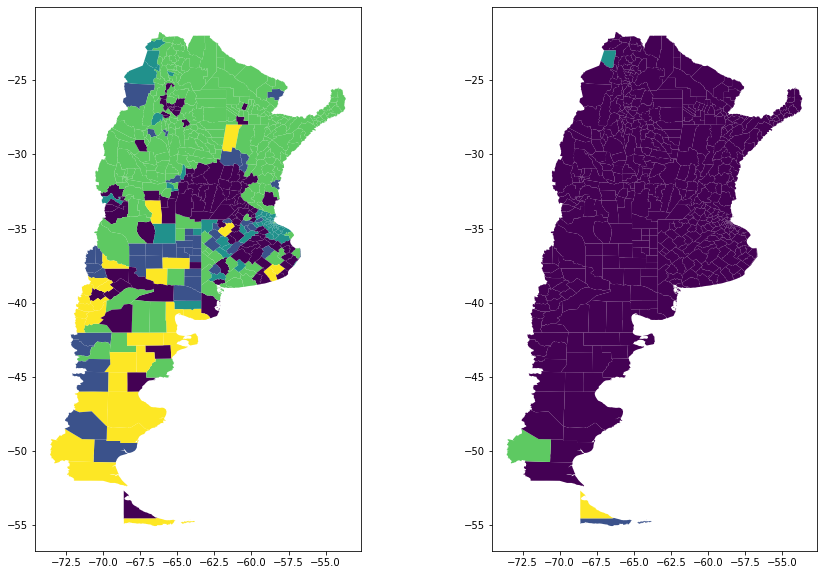

In [205]:
covid_rdos = pd.DataFrame(casos)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])


<AxesSubplot:>

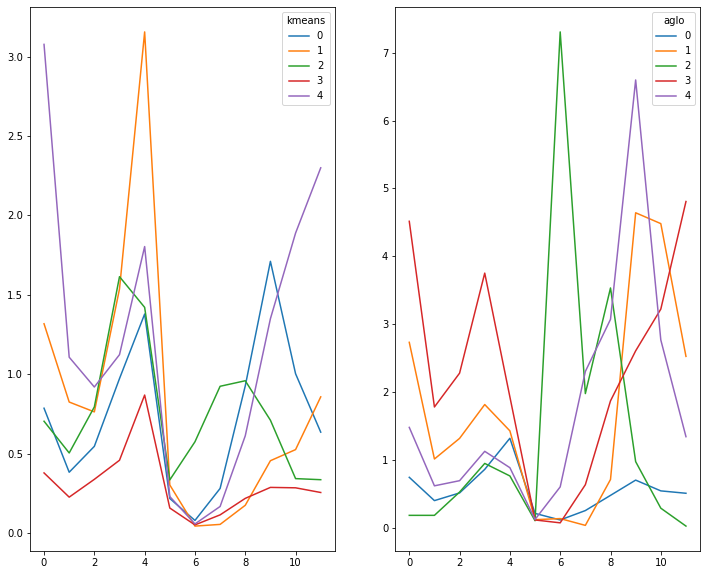

In [206]:
fig, ax = plt.subplots(1,2, figsize = (12,10))
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:11]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:11]).T.plot(ax = ax[1])

## Prueba considerando solo el promedio por departamento

<AxesSubplot:>

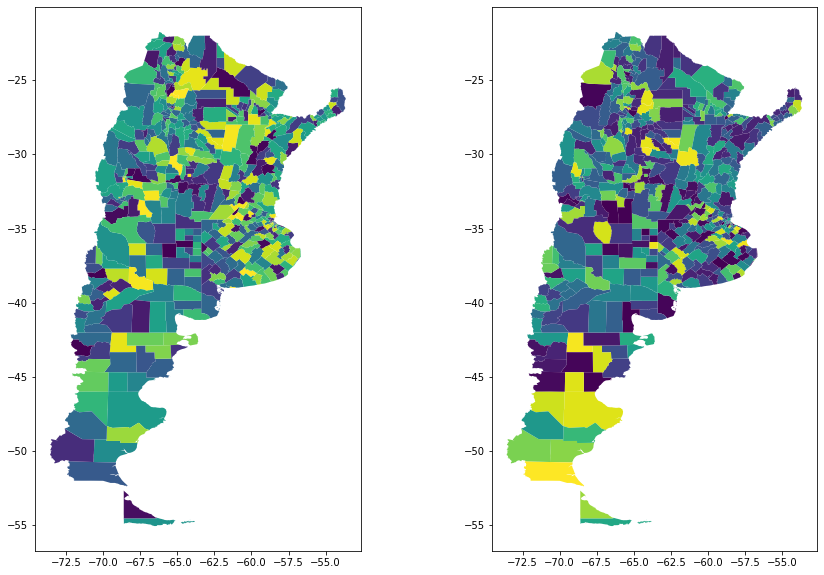

In [222]:
prom_casos = covid2['clasificac'].groupby(level = 0).mean().to_numpy().reshape(525,1)
kmeans.fit(prom_casos)
aglo.fit(prom_casos)

covid_rdos = pd.DataFrame(casos)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])


In [225]:
kmeans.best_model_

,modelo,Metrica,tiempo,Tamaño
61,"KMeans(n_clusters=80, n_init=12)",0.59252,0.574462,56


In [229]:
aglo.best_model_

,modelo,Metrica,tiempo,Tamaño
34,"AgglomerativeClustering(affinity='l1', linkage...",0.576322,0.009976,56
91,"AgglomerativeClustering(affinity='l2', linkage...",0.576322,0.009972,56
148,"AgglomerativeClustering(affinity='manhattan', ...",0.576322,0.009973,56


## Conisderando el coeficiente de localización

In [231]:
import scipy.stats as st
def lq(datos, campo, total):
    ind = datos[campo]/datos[total]
    indg = datos[campo].sum()/datos[total].sum()
    return [ind,indg,ind/indg]

def intervalos(data, campo, total, a = .95):
    indices = lq(data, campo,total) 
    pi = indices[0]
    p = indices[1]
    ni = data[total]
    n = data[total].sum()
    
    var = (pi*(1-pi)/(ni*p**2))+((pi**2)*(1-p)/(n*p**3))+(2*(pi**2)*(1-pi)/(n*p**3))
    sd = np.sqrt(var)
    sd
    np.mean(indices[2])
    sdnorm = st.t.ppf((1+a)/2,2)*sd
    #sdnorm = st.norm.ppf((1+a)/2)*sd
    
    return pd.DataFrame([indices[2]-sdnorm,indices[2]+sdnorm.T,sdnorm,indices[2]]).T 

### Primero consideremos ambos coeficientes con la población

<AxesSubplot:>

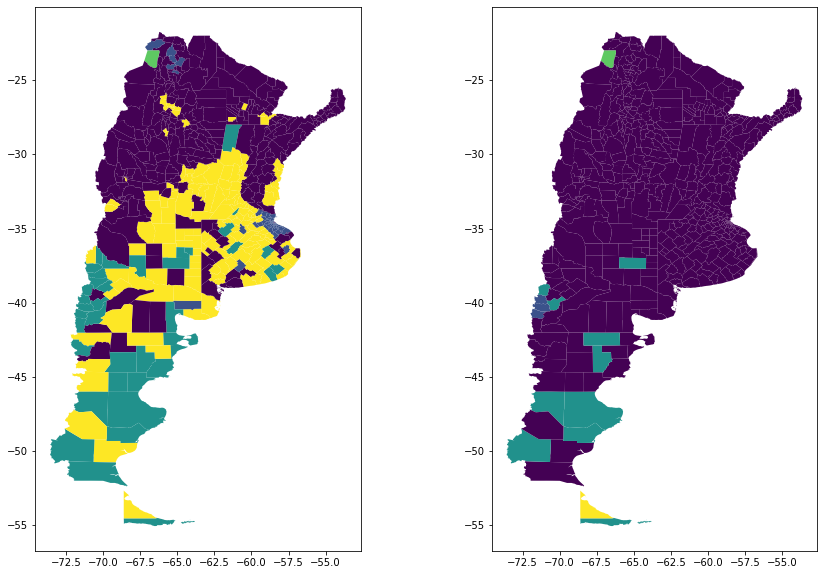

In [255]:
lq_confirm = covid[['lq_confirm']].to_numpy().reshape(525,12)
lq_fallec = covid[['lq_falleci']].to_numpy().reshape(525,12)

kmeans.fit(lq_confirm)
aglo.fit(lq_confirm)

covid_rdos = pd.DataFrame(lq_confirm)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])

In [256]:
pd.concat([kmeans.best_model_,aglo.best_model_])

,modelo,Metrica,tiempo,Tamaño
0,KMeans(n_clusters=5),0.279211,0.092750,56
1,"KMeans(n_clusters=5, n_init=12)",0.279211,0.110704,56
2,"KMeans(n_clusters=5, n_init=15)",0.279211,0.112698,56
3,"KMeans(n_clusters=5, n_init=20)",0.279211,0.168550,56
77,"KMeans(init='random', n_clusters=5, n_init=12)",0.279211,0.083776,56
78,"KMeans(init='random', n_clusters=5, n_init=15)",0.279211,0.104719,56
76,"AgglomerativeClustering(affinity='l2', linkage...",0.597877,0.011969,56


<AxesSubplot:>

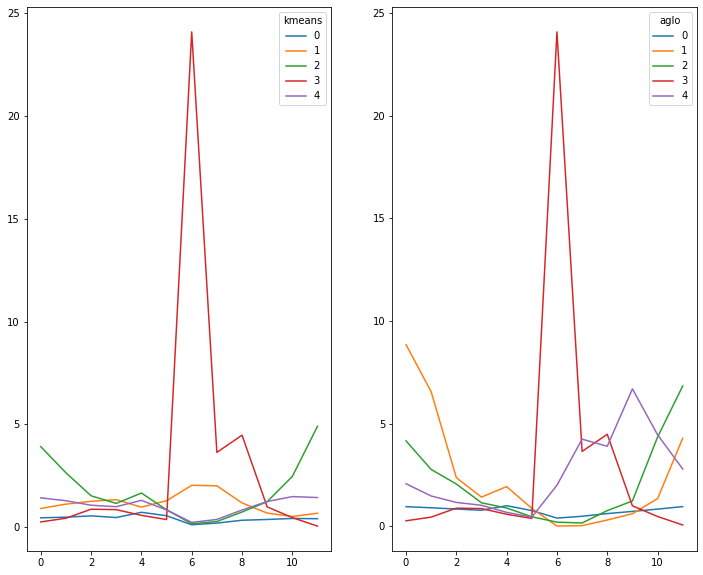

In [257]:
fig, ax = plt.subplots(1,2, figsize = (12,10))
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:11]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:11]).T.plot(ax = ax[1])

In [333]:
covid_rdos.query("aglo == 3")

,,0,1,2,3,4,5,6,7,8,9,10,11,kmeans,aglo,geometry
link,mes,,,,,,,,,,,,,,,
50014,1,1.102628,1.683283,3.004661,1.932131,1.397517,5.225497,80.12428,10.015535,0.593513,1.092604,1.347222,1.188284,1,3,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."


In [334]:
covid.loc[50014]

,clasificac,fallecido,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,lq_confirm,lq_falleci,geometry
mes,,,,,,,,,,,,,,
1,218.0,6.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.655028,0.891997,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
2,119.0,5.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.607586,1.109461,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
3,120.0,9.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.429083,1.420872,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
4,1016.0,49.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,1.968881,4.256395,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
5,516.0,18.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.839027,2.118919,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
6,23.0,3.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.174969,0.933433,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
7,2.0,4.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.014207,0.607842,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
8,12.0,3.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.047562,0.309621,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."
9,135.0,2.0,50,General Alvear,Mendoza,23879,22550,46429,14748,16795,14113,0.368326,0.160948,"POLYGON ((-66.69534 -34.66511, -66.69197 -34.6..."


## Probamos con fallecidos

<AxesSubplot:>

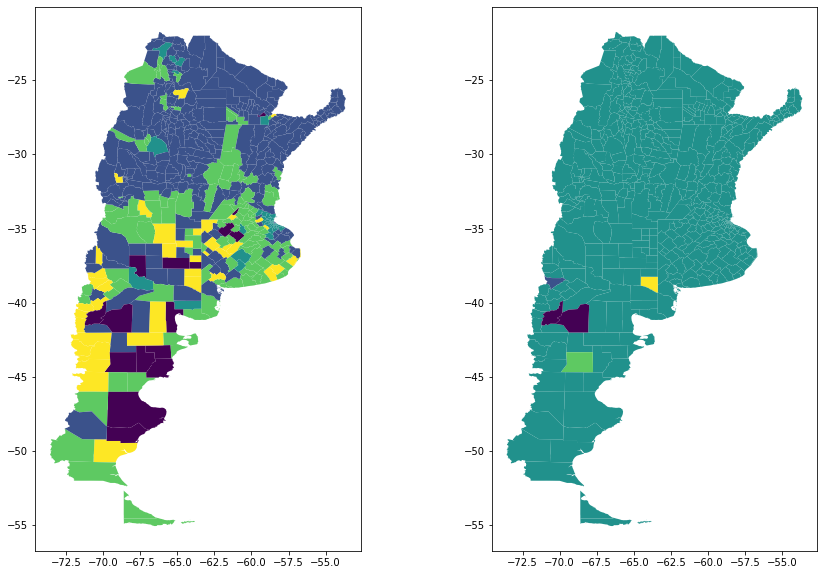

In [265]:
kmeans.fit(lq_fallec)
aglo.fit(lq_fallec)

covid_rdos = pd.DataFrame(lq_fallec)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])

In [266]:
pd.concat([kmeans.best_model_,aglo.best_model_])

,modelo,Metrica,tiempo,Tamaño
78,"KMeans(init='random', n_clusters=5, n_init=15)",0.245180,0.111701,56
19,"AgglomerativeClustering(affinity='l1', linkage...",0.580595,0.010971,56
133,"AgglomerativeClustering(affinity='manhattan', ...",0.580595,0.013963,56


<AxesSubplot:>

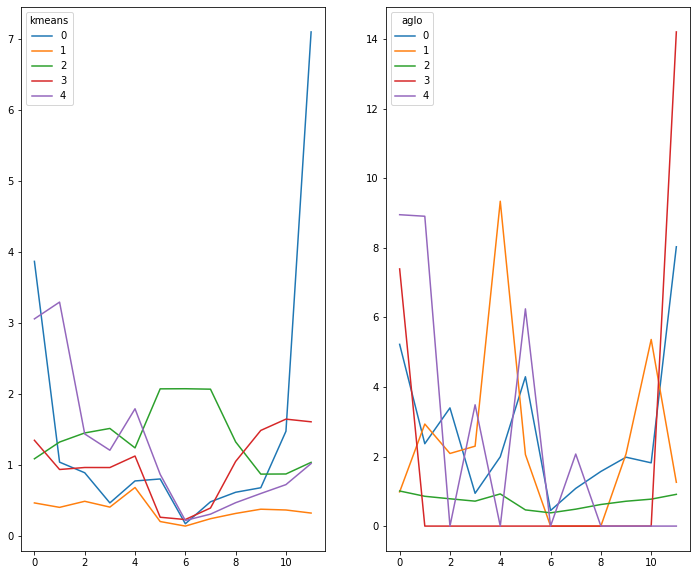

In [267]:
fig, ax = plt.subplots(1,2, figsize = (12,10))
pd.DataFrame(covid_rdos.groupby('kmeans').mean().loc[:,0:11]).T.plot(ax = ax[0])
pd.DataFrame(covid_rdos.groupby('aglo').mean().loc[:,0:11]).T.plot(ax = ax[1])

In [270]:
covid_rdos.query("aglo == 3")

,,0,1,2,3,4,5,6,7,8,9,10,11,kmeans,aglo,geometry
link,mes,,,,,,,,,,,,,,,
26070,1,7.394134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.20808,0,3,"POLYGON ((-68.37525 -44.68875, -68.90561 -44.6..."


In [289]:
silhouette_score(lq_fallec,codiprov),silhouette_score(lq_confirm,codiprov)


(-0.1834282445132097, -0.13930941062181604)

<AxesSubplot:>

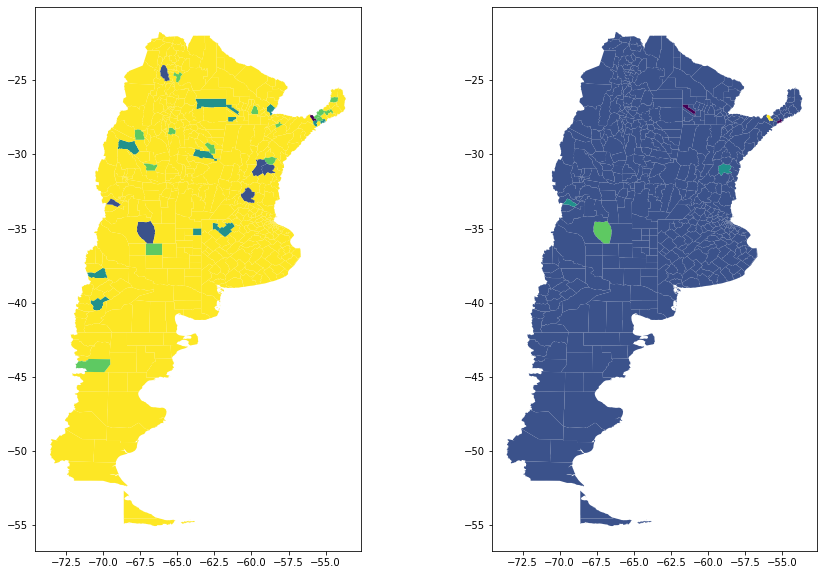

In [331]:

lq_fall_conf = lq(covid,'fallecido','clasificac')[2].fillna(0).replace(np.inf, 0)
lq_fall_conf = lq_fall_conf.to_numpy().reshape(525,12)

kmeans.fit(lq_fall_conf)
aglo.fit(lq_fall_conf)


covid_rdos = pd.DataFrame(lq_fall_conf)
covid_rdos['kmeans'] = kmeans.best_model_['modelo'].iloc[0].labels_
covid_rdos['aglo'] = aglo.best_model_['modelo'].iloc[0].labels_
covid_rdos = covid_rdos.set_index(geo.index)
covid_rdos = gpd.GeoDataFrame(covid_rdos, geometry = geo)

fig, ax = plt.subplots(1,2, figsize = (15,10))
covid_rdos.plot('kmeans', ax= ax[0])
covid_rdos.plot('aglo', ax= ax[1])

# Tensor flow

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [83]:
latent_dim = 12 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(24, activation='sigmoid'),
          layers.Reshape((12, 2))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [84]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [85]:
autoencoder.fit(dptos, dptos,
                epochs=10,
                shuffle=True,
                validation_data=(dptos, dptos))

Epoch 1/10
17/17 [==============================] - 0s 8ms/step - loss: 0.2446 - val_loss: 0.2414
Epoch 2/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2383 - val_loss: 0.2342
Epoch 3/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2303 - val_loss: 0.2251
Epoch 4/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2200 - val_loss: 0.2136
Epoch 5/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2075 - val_loss: 0.1998
Epoch 6/10
17/17 [==============================] - 0s 2ms/step - loss: 0.1928 - val_loss: 0.1839
Epoch 7/10
17/17 [==============================] - 0s 2ms/step - loss: 0.1760 - val_loss: 0.1661
Epoch 8/10
17/17 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1474
Epoch 9/10
17/17 [==============================] - 0s 2ms/step - loss: 0.1388 - val_loss: 0.1286
Epoch 10/10
17/17 [==============================] - 0s 2ms/step - loss: 0.1204 - val_loss: 0.1106


In [89]:
autoencoder.decoder(autoencoder.encoder(dptos))

<tf.Tensor: shape=(525, 12, 2), dtype=float32, numpy=
array([[[0.33884582, 0.35925922],
        [0.3157425 , 0.2685972 ],
        [0.37244368, 0.28933972],
        ...,
        [0.31397003, 0.2824757 ],
        [0.33347362, 0.34282708],
        [0.2979458 , 0.34316683]],

       [[0.33978564, 0.36042   ],
        [0.31775028, 0.2707832 ],
        [0.37374762, 0.2908721 ],
        ...,
        [0.31558043, 0.284168  ],
        [0.33431467, 0.34435654],
        [0.29950827, 0.3445495 ]],

       [[0.33871156, 0.35926175],
        [0.31545353, 0.26823312],
        [0.3725134 , 0.2891323 ],
        ...,
        [0.31361586, 0.28190804],
        [0.33294356, 0.34233937],
        [0.29728195, 0.34351954]],

       ...,

       [[0.33445573, 0.35449806],
        [0.31046265, 0.26273662],
        [0.36968863, 0.2829919 ],
        ...,
        [0.30898994, 0.2773884 ],
        [0.32893288, 0.3385127 ],
        [0.29149753, 0.33772987]],

       [[0.3238171 , 0.3443309 ],
        [0.2990929 , 0.

In [90]:
autoencoder.weights

[<tf.Variable 'dense_6/kernel:0' shape=(24, 12) dtype=float32, numpy=
 array([[ 3.50538731e-01, -1.59087405e-01,  4.42902356e-01,
          4.05792028e-01, -3.29584032e-01,  2.86653072e-01,
          3.45264018e-01,  4.16001499e-01,  1.41564697e-01,
         -3.92058402e-01,  3.28800142e-01,  5.60666859e-01],
        [ 3.74338664e-02, -3.42866108e-02, -2.12489054e-01,
          7.18770400e-02, -4.03544039e-01, -2.88088799e-01,
          1.06539898e-01,  5.07502139e-01, -8.98466036e-02,
          2.81357646e-01, -2.88729519e-02,  1.78345904e-01],
        [ 3.64226252e-01,  9.96536836e-02,  3.58589619e-01,
         -1.01399764e-01, -8.59231949e-02, -1.88296303e-01,
          1.51637152e-01,  6.14347816e-01,  1.25968829e-01,
         -2.07753956e-01,  2.58655339e-01,  2.20596090e-01],
        [ 5.67248464e-01,  2.86533237e-02, -4.41944413e-03,
          2.79047400e-01,  3.79526019e-01,  2.99477786e-01,
         -1.45797983e-01,  2.43649669e-02,  4.07965600e-01,
          5.18885888e-02,  

In [92]:
import keras
initial_model = keras.Sequential(
    [
        keras.Input(shape=(250, 250, 3)),
        layers.Conv2D(32, 5, strides=2, activation="relu"),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Conv2D(32, 3, activation="relu"),
    ]
)
feature_extractor = keras.Model(
    inputs=initial_model.inputs,
    outputs=[layer.output for layer in initial_model.layers],
)

# Call feature extractor on test input.
x = tf.ones((1, 250, 250, 3))
features = feature_extractor(x)

In [93]:
features

[<tf.Tensor: shape=(1, 123, 123, 32), dtype=float32, numpy=
 array([[[[0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          [0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          [0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          ...,
          [0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          [0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          [0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ]],
 
         [[0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          [0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          [0.28021166, 0.        , 0.01612701, ..., 0.        ,
           0.3553673 , 0.        ],
          ...,
       